In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

from transformers import BertTokenizer, TFBertForSequenceClassification


In [ ]:

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


TensorFlow version: 2.18.0
Num GPUs Available:  1


In [ ]:

fake = pd.read_csv('/content/drive/MyDrive/fake news /dataset/Fake.csv')
real = pd.read_csv('/content/drive/MyDrive/fake news /dataset/True.csv')


In [ ]:
print(fake.head())
print(real.head())

print(fake.isnull().sum())
print(real.isnull().sum())

print(f"Fake Shape: {fake.shape}")
print(f"Real Shape: {real.shape}")

print("information of fake " , fake.info())
print("information of real" , real.info())

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017  
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept t

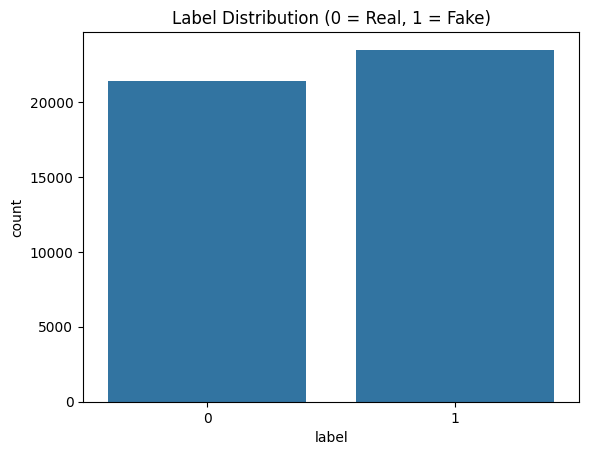

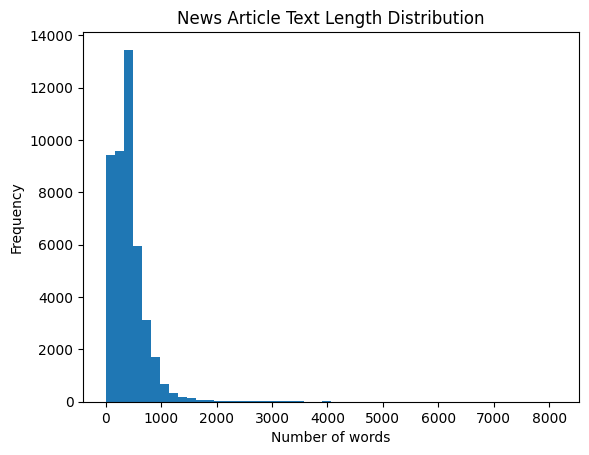

In [ ]:
# Add labels
fake['label'] = 1
real['label'] = 0

# Combine
df = pd.concat([fake, real])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Label Distribution
sns.countplot(x='label', data=df)
plt.title("Label Distribution (0 = Real, 1 = Fake)")
plt.show()

# Text Length Distribution
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))
plt.hist(df['text_length'], bins=50)
plt.title("News Article Text Length Distribution")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()


In [ ]:
texts = df['text'].tolist()
labels = df['label'].tolist()

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42)


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=256)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Train dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': train_encodings['input_ids'],
        'attention_mask': train_encodings['attention_mask']
    },
    train_labels
)).batch(8)

# Validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': val_encodings['input_ids'],
        'attention_mask': val_encodings['attention_mask']
    },
    val_labels
)).batch(8)


In [ ]:
from transformers import TFDistilBertForSequenceClassification

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=3)


Epoch 1/3
4490/4490 [==============================] - 1092s 238ms/step - loss: 0.0087 - accuracy: 0.9974 - val_loss: 0.0010 - val_accuracy: 0.9999
Epoch 2/3
4490/4490 [==============================] - 1065s 237ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0029 - val_accuracy: 0.9997
Epoch 3/3
4490/4490 [==============================] - 1064s 237ms/step - loss: 3.3390e-04 - accuracy: 1.0000 - val_loss: 5.1881e-04 - val_accuracy: 0.9999


In [ ]:
loss, accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

1123/1123 [==============================] - 86s 76ms/step - loss: 5.1881e-04 - accuracy: 0.9999
Validation Loss: 0.0005188109935261309
Validation Accuracy: 0.9998886585235596


In [ ]:
# Predict labels
y_pred_probs = model.predict(val_dataset).logits
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
print(classification_report(val_labels, y_pred))


1123/1123 [==============================] - 85s 74ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4270
           1       1.00      1.00      1.00      4710

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



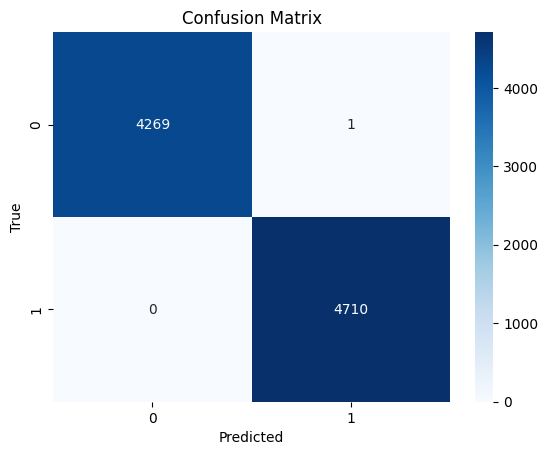

In [ ]:
cm = confusion_matrix(val_labels, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


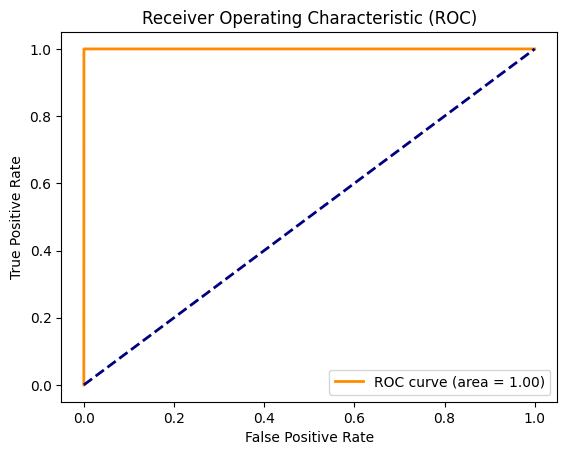

In [ ]:
fpr, tpr, thresholds = roc_curve(val_labels, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


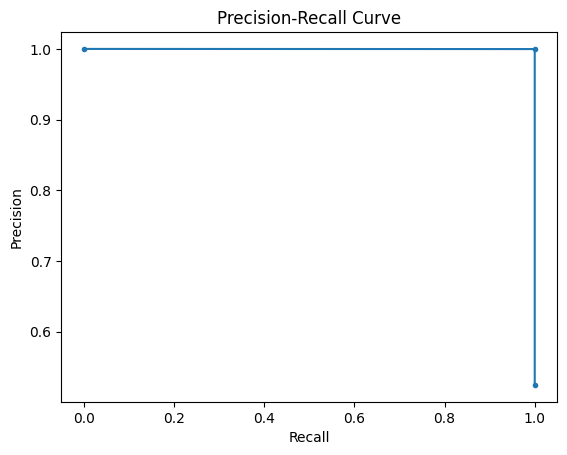

In [ ]:
precision, recall, thresholds = precision_recall_curve(val_labels, y_pred)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


In [ ]:
# Save the model
model.save_pretrained('/content/drive/MyDrive/fake news')

# Save the tokenizer
tokenizer.save_pretrained('/content/drive/MyDrive/fake news')


('/content/drive/MyDrive/fake news/tokenizer_config.json',
 '/content/drive/MyDrive/fake news/special_tokens_map.json',
 '/content/drive/MyDrive/fake news/vocab.txt',
 '/content/drive/MyDrive/fake news/added_tokens.json')